### Initialization

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import hog
import glob
import matplotlib.image as mpimg
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.svm import LinearSVC
import time
from scipy.ndimage.measurements import label


/home/supreeth/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Helpers

In [2]:
def getRGBImage(bgrImage):
    rgbImage = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return rgbImage

### Draw Rectangle

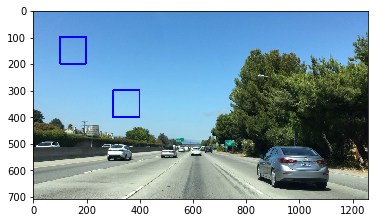

In [3]:
def drawBoxes( image, bBoxes, color=(0,0,255), thickness = 6):
    
    for bBox in bBoxes:
        cv2.rectangle(image, bBox[0], bBox[1], color, thickness)
        
    return image

image = cv2.imread('downloaded_images/bbox-example-image.jpg')
rgbImage = getRGBImage(image)

bBoxes = [((100, 100), (200, 200)), ((300, 300), (400, 400))]

result = drawBoxes(rgbImage, bBoxes)
plt.imshow(result)
plt.show()

### Color Histogram

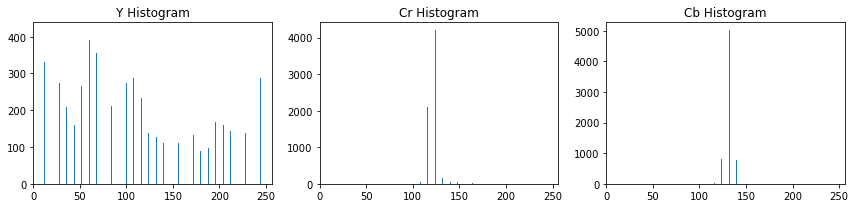

In [102]:
def colorHistogram( image, numberOfBins = 32, binRange = (0,256) ):
    
    redHist   = np.histogram( image[:,:,0], numberOfBins, binRange )
    greenHist = np.histogram( image[:,:,1], numberOfBins, binRange )
    blueHist  = np.histogram( image[:,:,2], numberOfBins, binRange )
    
    binEdges = redHist[1]
    binCenters = (binEdges[1:]  + binEdges[0:len(binEdges)-1])/2
    
    histogramFeatures = np.concatenate( (redHist[0], greenHist[0], blueHist[0]) )
    
    return redHist, greenHist, blueHist, binCenters, histogramFeatures


image = cv2.imread('downloaded_images/cutout1.jpg')
rgbImage = getRGBImage(image)

ycrcb = cv2.cvtColor(rgbImage, cv2.COLOR_RGB2YCrCb)

redHist, greenHist, blueHist, binCenters, histogramFeatures = colorHistogram(ycrcb, numberOfBins=32, binRange=(0, 256))

# Plot a figure with all three bar charts
if redHist is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.bar(binCenters, redHist[0])
    plt.xlim(0, 256)
    plt.title('Y Histogram')
    plt.subplot(132)
    plt.bar(binCenters, greenHist[0])
    plt.xlim(0, 256)
    plt.title('Cr Histogram')
    plt.subplot(133)
    plt.bar(binCenters, blueHist[0])
    plt.xlim(0, 256)
    plt.title('Cb Histogram')
    fig.tight_layout()
    plt.savefig('output_images/Histogram.png')
    plt.show()
else:
    print('Your function is returning None for at least one variable...')    

### Spatial Binning of Color

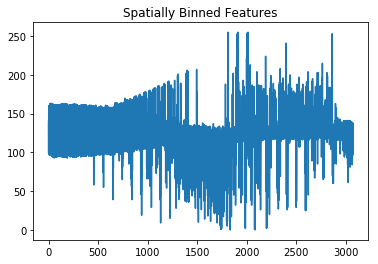

In [99]:
def binSpatial( image, colorSpace = 'RGB', size = (32,32) ):

    if colorSpace != 'RGB':
        if colorSpace == 'HSV':
            featureImage = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif colorSpace == 'LUV':
            featureImage = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif colorSpace == 'HLS':
            featureImage = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif colorSpace == 'YUV':
            featureImage = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif colorSpace == 'YCrCb':
            featureImage = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: 
        featureImage = np.copy(image)             
    features = cv2.resize(featureImage, size).ravel() 

    return features

featurevector = binSpatial(image, colorSpace='YCrCb', size=(32, 32))

# Plot features
plt.plot(featurevector)
plt.title('Spatially Binned Features')
plt.savefig('output_images/SpatialFeatures.png')
plt.show()

### Data exploration

Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: uint8


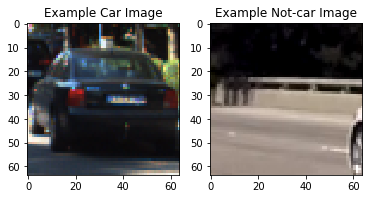

In [90]:
carList_GTIFar = glob.glob('vehicles/vehicles/GTI_Far/*.png')
carList_GTILeft = glob.glob('vehicles/vehicles/GTI_Left/*.png')
carList_GTIMiddle = glob.glob('vehicles/vehicles/GTI_MiddleClose/*.png')
carList_GTIRight = glob.glob('vehicles/vehicles/GTI_Right/*.png')
carList_KITTI = glob.glob('vehicles/vehicles/KITTI_extracted/*.png')

notCarList_GTI = glob.glob('non-vehicles/non-vehicles/GTI/*.png')
notCarList_Extra = glob.glob('non-vehicles/non-vehicles/Extras/*.png')

cars = np.concatenate( (carList_GTIFar, carList_GTILeft, carList_GTIMiddle, carList_GTIRight, carList_KITTI))
notCars = np.concatenate( (notCarList_GTI, notCarList_Extra) )

# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = cv2.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict

data_info = data_look(cars, notCars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notCars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notCars[notcar_ind])


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')
plt.show()

TF = mpimg.imsave('output_images/carImage.png', car_image)
TF = mpimg.imsave('output_images/notCarImage.png', notcar_image)

### HOG Features

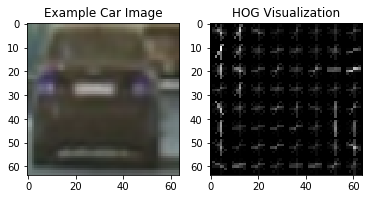

In [97]:
def getHOGFeatures(image, orientation, pixPerCell, cellPerBlock, visualize=False, featureVec=True):
    if visualize == True:
        features, hogImage = hog(image, orientations=orientation, pixels_per_cell=(pixPerCell, pixPerCell),
                                  cells_per_block=(cellPerBlock, cellPerBlock), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hogImage
    else:      
        features = hog(image, orientations=orientation, pixels_per_cell=(pixPerCell, pixPerCell),
                       cells_per_block=(cellPerBlock, cellPerBlock), transform_sqrt=False, 
                       visualise=False, feature_vector=featureVec)
        return features
    
image = cv2.imread('vehicles/vehicles/GTI_MiddleClose/image0000.png')
rgbImage = getRGBImage(image)
gray = cv2.cvtColor(rgbImage, cv2.COLOR_RGB2GRAY)

ycrcb = cv2.cvtColor(rgbImage, cv2.COLOR_RGB2YCrCb)
gray = ycrcb[:,:,2]
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = getHOGFeatures(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        visualize=True, featureVec=False)


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')
plt.show()

TF = mpimg.imsave('output_images/hogCarImage.png', image )
TF = mpimg.imsave('output_images/hogFeatures.png', hog_image, cmap='gray' )

### Extract Features

In [8]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

# Define a function to compute color histogram features 
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

### Sliding Window

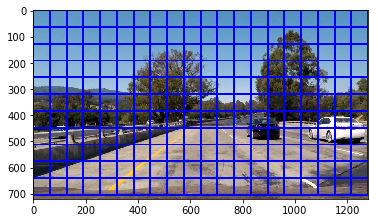

In [9]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

image = mpimg.imread('test_images/test1.jpg')

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
                       
window_img = drawBoxes(image, windows, color=(0, 0, 255), thickness=6)                    
plt.imshow(image)
plt.show()

### Search Windows

In [10]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

### Train model

In [11]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 64    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notCars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)



/home/supreeth/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [12]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8556
24.77 Seconds to train SVC...
Test Accuracy of SVC =  0.993


### Find Cars

In [122]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bBoxes = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bBoxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
#                 cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return bBoxes

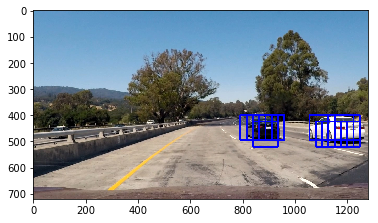

In [121]:

img = mpimg.imread('test_images/test1.jpg')

ystart = 400
ystop = 656
scale = 1.5
    
out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

plt.imshow(out_img)
plt.show()


In [123]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


In [133]:
def pipeline(image):
    
    scales = np.arange(1.0, 2.5, ((2.5-1.0)/10))
    y_start_stops = []
    for scale in scales:
        y_start_stops.append([400, 656])
    
    bbox_list = []
    
    global heatmap_sum
    global heatmaps

    heat_thresh = 15    
    
    for scale, y_start_stop in zip(scales, y_start_stops):
        boxes = find_cars(image, int(y_start_stop[0]), int(y_start_stop[1]), scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        if not boxes == None:
            if not len(boxes) == 0:
                bbox_list.append(boxes)

    if(len(bbox_list) != 0):
        bbox_list = np.concatenate(bbox_list)

    heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
    
    # Add heat to each box in box list
    heatmap = add_heat(heatmap, bbox_list)
    heatmaps.append(heatmap)

    heatmapSum = heatmap
    
    mpimg.imsave('output_images/heatmap.png', heatmapSum)
    if len(heatmaps) > 10:
        heatmapSum = sum(heatmaps[:]) // 10
        oldHeatMap = heatmaps.pop(0)

    thresh_heat = apply_threshold(heatmapSum, heat_thresh)

    labels = label(thresh_heat)

    result = draw_labeled_bboxes(image, labels)

    return result

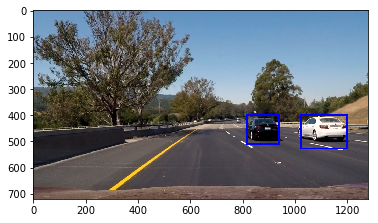

In [134]:
heatmap_sum = np.zeros((720,1280)).astype(np.float64)
heatmaps = []

image = mpimg.imread('test_images/test6.jpg')
result = pipeline(image)
plt.imshow(result)
plt.show()
# ret = mpimg.imsave('output_images/test5Out.png', result)

In [78]:

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

projectVideo_output = "project_video_output.mp4"
clip1 = VideoFileClip("project_video.mp4")

heatmap_sum = np.zeros((720,1280)).astype(np.float64)
heatmaps = []

clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time clip.write_videofile(projectVideo_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4





  0%|          | 0/1261 [00:00<?, ?it/s]


  0%|          | 1/1261 [00:04<1:31:13,  4.34s/it]


  0%|          | 2/1261 [00:08<1:29:00,  4.24s/it]


  0%|          | 3/1261 [00:12<1:27:08,  4.16s/it]


  0%|          | 4/1261 [00:16<1:26:04,  4.11s/it]


  0%|          | 5/1261 [00:20<1:25:28,  4.08s/it]


  0%|          | 6/1261 [00:24<1:25:41,  4.10s/it]


  1%|          | 7/1261 [00:28<1:27:05,  4.17s/it]


  1%|          | 8/1261 [00:32<1:25:50,  4.11s/it]


  1%|          | 9/1261 [00:36<1:25:07,  4.08s/it]


  1%|          | 10/1261 [00:40<1:24:42,  4.06s/it]


  1%|          | 11/1261 [00:44<1:24:39,  4.06s/it]


  1%|          | 12/1261 [00:49<1:25:15,  4.10s/it]


  1%|          | 13/1261 [00:53<1:24:51,  4.08s/it]


  1%|          | 14/1261 [00:57<1:26:21,  4.16s/it]


  1%|          | 15/1261 [01:01<1:25:36,  4.12s/it]


  1%|▏         | 16/1261 [01:05<1:26:15,  4.16s/it]


  1%|▏         | 17/1261 [01:10<1:27:36,  4.23s/it]


  1%|▏         | 18/1261 [01:14<1:27:26,  4.2

 10%|█         | 129/1261 [09:22<1:22:26,  4.37s/it]


 10%|█         | 130/1261 [09:26<1:22:26,  4.37s/it]


 10%|█         | 131/1261 [09:30<1:22:04,  4.36s/it]


 10%|█         | 132/1261 [09:35<1:21:47,  4.35s/it]


 11%|█         | 133/1261 [09:39<1:21:41,  4.35s/it]


 11%|█         | 134/1261 [09:43<1:21:41,  4.35s/it]


 11%|█         | 135/1261 [09:48<1:22:25,  4.39s/it]


 11%|█         | 136/1261 [09:52<1:23:20,  4.45s/it]


 11%|█         | 137/1261 [09:57<1:22:21,  4.40s/it]


 11%|█         | 138/1261 [10:01<1:21:45,  4.37s/it]


 11%|█         | 139/1261 [10:05<1:21:36,  4.36s/it]


 11%|█         | 140/1261 [10:10<1:22:00,  4.39s/it]


 11%|█         | 141/1261 [10:14<1:21:26,  4.36s/it]


 11%|█▏        | 142/1261 [10:19<1:22:03,  4.40s/it]


 11%|█▏        | 143/1261 [10:23<1:22:05,  4.41s/it]


 11%|█▏        | 144/1261 [10:27<1:21:50,  4.40s/it]


 11%|█▏        | 145/1261 [10:32<1:22:01,  4.41s/it]


 12%|█▏        | 146/1261 [10:36<1:21:40,  4.40s/it]


 12%|█▏   

 20%|██        | 257/1261 [18:43<1:12:13,  4.32s/it]


 20%|██        | 258/1261 [18:47<1:12:25,  4.33s/it]


 21%|██        | 259/1261 [18:51<1:12:23,  4.33s/it]


 21%|██        | 260/1261 [18:56<1:14:09,  4.45s/it]


 21%|██        | 261/1261 [19:01<1:15:30,  4.53s/it]


 21%|██        | 262/1261 [19:05<1:16:07,  4.57s/it]


 21%|██        | 263/1261 [19:10<1:15:08,  4.52s/it]


 21%|██        | 264/1261 [19:14<1:14:06,  4.46s/it]


 21%|██        | 265/1261 [19:18<1:13:43,  4.44s/it]


 21%|██        | 266/1261 [19:23<1:13:13,  4.42s/it]


 21%|██        | 267/1261 [19:27<1:12:54,  4.40s/it]


 21%|██▏       | 268/1261 [19:32<1:12:40,  4.39s/it]


 21%|██▏       | 269/1261 [19:36<1:12:45,  4.40s/it]


 21%|██▏       | 270/1261 [19:40<1:12:27,  4.39s/it]


 21%|██▏       | 271/1261 [19:45<1:12:08,  4.37s/it]


 22%|██▏       | 272/1261 [19:49<1:12:05,  4.37s/it]


 22%|██▏       | 273/1261 [19:53<1:11:51,  4.36s/it]


 22%|██▏       | 274/1261 [19:58<1:11:35,  4.35s/it]


 22%|██▏  

 31%|███       | 385/1261 [28:02<1:04:12,  4.40s/it]


 31%|███       | 386/1261 [28:07<1:04:12,  4.40s/it]


 31%|███       | 387/1261 [28:11<1:03:50,  4.38s/it]


 31%|███       | 388/1261 [28:15<1:03:49,  4.39s/it]


 31%|███       | 389/1261 [28:20<1:03:48,  4.39s/it]


 31%|███       | 390/1261 [28:24<1:03:28,  4.37s/it]


 31%|███       | 391/1261 [28:28<1:03:07,  4.35s/it]


 31%|███       | 392/1261 [28:33<1:02:52,  4.34s/it]


 31%|███       | 393/1261 [28:37<1:02:50,  4.34s/it]


 31%|███       | 394/1261 [28:41<1:02:53,  4.35s/it]


 31%|███▏      | 395/1261 [28:46<1:02:31,  4.33s/it]


 31%|███▏      | 396/1261 [28:50<1:02:15,  4.32s/it]


 31%|███▏      | 397/1261 [28:54<1:02:24,  4.33s/it]


 32%|███▏      | 398/1261 [28:59<1:02:37,  4.35s/it]


 32%|███▏      | 399/1261 [29:03<1:03:17,  4.41s/it]


 32%|███▏      | 400/1261 [29:08<1:03:05,  4.40s/it]


 32%|███▏      | 401/1261 [29:12<1:02:47,  4.38s/it]


 32%|███▏      | 402/1261 [29:16<1:02:11,  4.34s/it]


 32%|███▏ 

 41%|████      | 515/1261 [37:29<54:20,  4.37s/it]


 41%|████      | 516/1261 [37:33<54:30,  4.39s/it]


 41%|████      | 517/1261 [37:38<54:12,  4.37s/it]


 41%|████      | 518/1261 [37:42<53:58,  4.36s/it]


 41%|████      | 519/1261 [37:46<53:46,  4.35s/it]


 41%|████      | 520/1261 [37:51<54:22,  4.40s/it]


 41%|████▏     | 521/1261 [37:55<54:17,  4.40s/it]


 41%|████▏     | 522/1261 [38:00<53:59,  4.38s/it]


 41%|████▏     | 523/1261 [38:04<53:44,  4.37s/it]


 42%|████▏     | 524/1261 [38:08<53:26,  4.35s/it]


 42%|████▏     | 525/1261 [38:13<53:25,  4.35s/it]


 42%|████▏     | 526/1261 [38:17<53:13,  4.34s/it]


 42%|████▏     | 527/1261 [38:21<53:24,  4.37s/it]


 42%|████▏     | 528/1261 [38:26<53:11,  4.35s/it]


 42%|████▏     | 529/1261 [38:30<53:07,  4.35s/it]


 42%|████▏     | 530/1261 [38:35<53:08,  4.36s/it]


 42%|████▏     | 531/1261 [38:39<53:03,  4.36s/it]


 42%|████▏     | 532/1261 [38:43<53:01,  4.36s/it]


 42%|████▏     | 533/1261 [38:48<54:08,  4.46s

 51%|█████▏    | 647/1261 [47:08<44:46,  4.37s/it]


 51%|█████▏    | 648/1261 [47:13<44:51,  4.39s/it]


 51%|█████▏    | 649/1261 [47:17<44:36,  4.37s/it]


 52%|█████▏    | 650/1261 [47:21<44:23,  4.36s/it]


 52%|█████▏    | 651/1261 [47:26<44:21,  4.36s/it]


 52%|█████▏    | 652/1261 [47:30<44:21,  4.37s/it]


 52%|█████▏    | 653/1261 [47:34<44:14,  4.37s/it]


 52%|█████▏    | 654/1261 [47:39<44:26,  4.39s/it]


 52%|█████▏    | 655/1261 [47:43<44:28,  4.40s/it]


 52%|█████▏    | 656/1261 [47:48<44:08,  4.38s/it]


 52%|█████▏    | 657/1261 [47:52<44:11,  4.39s/it]


 52%|█████▏    | 658/1261 [47:56<43:55,  4.37s/it]


 52%|█████▏    | 659/1261 [48:01<43:58,  4.38s/it]


 52%|█████▏    | 660/1261 [48:05<43:40,  4.36s/it]


 52%|█████▏    | 661/1261 [48:09<43:36,  4.36s/it]


 52%|█████▏    | 662/1261 [48:14<43:32,  4.36s/it]


 53%|█████▎    | 663/1261 [48:18<43:16,  4.34s/it]


 53%|█████▎    | 664/1261 [48:23<43:26,  4.37s/it]


 53%|█████▎    | 665/1261 [48:27<43:05,  4.34s

 62%|██████▏   | 779/1261 [56:36<36:32,  4.55s/it]


 62%|██████▏   | 780/1261 [56:40<35:37,  4.44s/it]


 62%|██████▏   | 781/1261 [56:44<35:18,  4.41s/it]


 62%|██████▏   | 782/1261 [56:49<35:04,  4.39s/it]


 62%|██████▏   | 783/1261 [56:53<34:49,  4.37s/it]


 62%|██████▏   | 784/1261 [56:57<34:48,  4.38s/it]


 62%|██████▏   | 785/1261 [57:02<34:55,  4.40s/it]


 62%|██████▏   | 786/1261 [57:06<34:41,  4.38s/it]


 62%|██████▏   | 787/1261 [57:10<34:30,  4.37s/it]


 62%|██████▏   | 788/1261 [57:15<34:24,  4.37s/it]


 63%|██████▎   | 789/1261 [57:19<34:11,  4.35s/it]


 63%|██████▎   | 790/1261 [57:24<34:22,  4.38s/it]


 63%|██████▎   | 791/1261 [57:28<34:23,  4.39s/it]


 63%|██████▎   | 792/1261 [57:32<34:09,  4.37s/it]


 63%|██████▎   | 793/1261 [57:37<34:06,  4.37s/it]


 63%|██████▎   | 794/1261 [57:41<33:59,  4.37s/it]


 63%|██████▎   | 795/1261 [57:45<33:53,  4.36s/it]


 63%|██████▎   | 796/1261 [57:50<33:48,  4.36s/it]


 63%|██████▎   | 797/1261 [57:54<33:57,  4.39s

 72%|███████▏  | 908/1261 [1:06:02<25:59,  4.42s/it]


 72%|███████▏  | 909/1261 [1:06:07<27:11,  4.63s/it]


 72%|███████▏  | 910/1261 [1:06:11<26:35,  4.55s/it]


 72%|███████▏  | 911/1261 [1:06:15<26:15,  4.50s/it]


 72%|███████▏  | 912/1261 [1:06:20<25:54,  4.45s/it]


 72%|███████▏  | 913/1261 [1:06:24<25:40,  4.43s/it]


 72%|███████▏  | 914/1261 [1:06:29<25:25,  4.40s/it]


 73%|███████▎  | 915/1261 [1:06:33<25:11,  4.37s/it]


 73%|███████▎  | 916/1261 [1:06:37<25:07,  4.37s/it]


 73%|███████▎  | 917/1261 [1:06:41<24:56,  4.35s/it]


 73%|███████▎  | 918/1261 [1:06:46<24:49,  4.34s/it]


 73%|███████▎  | 919/1261 [1:06:50<24:48,  4.35s/it]


 73%|███████▎  | 920/1261 [1:06:55<24:42,  4.35s/it]


 73%|███████▎  | 921/1261 [1:06:59<24:40,  4.35s/it]


 73%|███████▎  | 922/1261 [1:07:03<24:32,  4.34s/it]


 73%|███████▎  | 923/1261 [1:07:08<24:33,  4.36s/it]


 73%|███████▎  | 924/1261 [1:07:12<24:25,  4.35s/it]


 73%|███████▎  | 925/1261 [1:07:16<24:15,  4.33s/it]


 73%|█████

 82%|████████▏ | 1035/1261 [1:15:21<16:45,  4.45s/it]


 82%|████████▏ | 1036/1261 [1:15:26<16:30,  4.40s/it]


 82%|████████▏ | 1037/1261 [1:15:30<16:26,  4.40s/it]


 82%|████████▏ | 1038/1261 [1:15:35<16:20,  4.40s/it]


 82%|████████▏ | 1039/1261 [1:15:39<16:13,  4.38s/it]


 82%|████████▏ | 1040/1261 [1:15:43<16:06,  4.37s/it]


 83%|████████▎ | 1041/1261 [1:15:48<15:57,  4.35s/it]


 83%|████████▎ | 1042/1261 [1:15:52<15:50,  4.34s/it]


 83%|████████▎ | 1043/1261 [1:15:56<16:01,  4.41s/it]


 83%|████████▎ | 1044/1261 [1:16:01<15:50,  4.38s/it]


 83%|████████▎ | 1045/1261 [1:16:05<15:37,  4.34s/it]


 83%|████████▎ | 1046/1261 [1:16:09<15:34,  4.35s/it]


 83%|████████▎ | 1047/1261 [1:16:14<15:33,  4.36s/it]


 83%|████████▎ | 1048/1261 [1:16:18<15:42,  4.42s/it]


 83%|████████▎ | 1049/1261 [1:16:23<15:35,  4.41s/it]


 83%|████████▎ | 1050/1261 [1:16:27<15:28,  4.40s/it]


 83%|████████▎ | 1051/1261 [1:16:31<15:18,  4.37s/it]


 83%|████████▎ | 1052/1261 [1:16:36<15:09,  4.35

 92%|█████████▏| 1161/1261 [1:24:34<07:19,  4.39s/it]


 92%|█████████▏| 1162/1261 [1:24:38<07:14,  4.39s/it]


 92%|█████████▏| 1163/1261 [1:24:43<07:08,  4.38s/it]


 92%|█████████▏| 1164/1261 [1:24:47<07:01,  4.35s/it]


 92%|█████████▏| 1165/1261 [1:24:51<07:02,  4.41s/it]


 92%|█████████▏| 1166/1261 [1:24:56<07:00,  4.43s/it]


 93%|█████████▎| 1167/1261 [1:25:00<06:53,  4.40s/it]


 93%|█████████▎| 1168/1261 [1:25:05<06:47,  4.39s/it]


 93%|█████████▎| 1169/1261 [1:25:09<06:40,  4.36s/it]


 93%|█████████▎| 1170/1261 [1:25:13<06:36,  4.35s/it]


 93%|█████████▎| 1171/1261 [1:25:18<06:33,  4.37s/it]


 93%|█████████▎| 1172/1261 [1:25:22<06:34,  4.44s/it]


 93%|█████████▎| 1173/1261 [1:25:27<06:29,  4.42s/it]


 93%|█████████▎| 1174/1261 [1:25:31<06:23,  4.41s/it]


 93%|█████████▎| 1175/1261 [1:25:35<06:19,  4.41s/it]


 93%|█████████▎| 1176/1261 [1:25:40<06:11,  4.37s/it]


 93%|█████████▎| 1177/1261 [1:25:44<06:06,  4.36s/it]


 93%|█████████▎| 1178/1261 [1:25:48<06:04,  4.39

[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 3h 17min 43s, sys: 36.8 s, total: 3h 18min 20s
Wall time: 1h 31min 49s


In [ ]:
#             xbox_left = np.int(xleft*scale)
#             ytop_draw = np.int(ytop*scale)
#             win_draw = np.int(window*scale)
#             bBoxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))